In [1]:
#from comet_ml import Experiment
import json
import wandb
import os
import yaml

In [2]:
import os

In [3]:
with open("/glock/gun/notebooks/api_key.txt", "r") as f:
    api_key = json.load(f)
    print("opened")
os.environ["WANDB_API_KEY"] = api_key["api_key"]

opened


In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("weapons", {}, "/glock/dzie/trainval.json", "/glock/dzie")
register_coco_instances("weapons_test", {}, "/Pobrane/test_edge.json", "/Pobrane/edgetest_images")
from notebook.services.config import ConfigManager
cm = ConfigManager().update('notebook', {'limit_output': 1000000})

In [5]:
from detectron2.data import MetadataCatalog
from detectron2.data import DatasetCatalog

In [6]:
dataset_dicts = DatasetCatalog.get("weapons")
dataset_metadata = MetadataCatalog.get("weapons")
dataset_dicts_test = DatasetCatalog.get("weapons_test")
dataset_metadata_test = MetadataCatalog.get("weapons_test")

In [7]:
import matplotlib.pyplot as plt
import random
from detectron2.utils.visualizer import Visualizer
import cv2

/Pobrane/edgetest_images/kjj.jpg


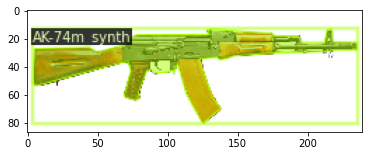

In [8]:
for d in random.sample(dataset_dicts_test, 1):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata_test, scale=0.3)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

/glock/dzie/RGBd6f1efad-c001-40d8-bdd7-ebdae31e2170/rgb_5.png
/glock/dzie/RGBd6f1efad-c001-40d8-bdd7-ebdae31e2170/rgb_8.png
/glock/dzie/RGBd6f1efad-c001-40d8-bdd7-ebdae31e2170/rgb_7.png


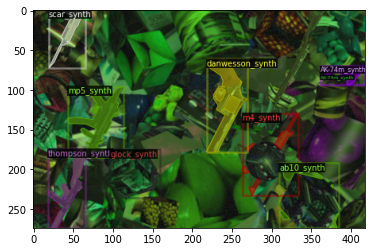

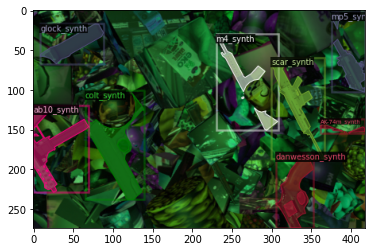

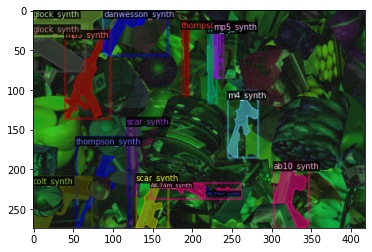

In [9]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    print(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [10]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

In [11]:
from datetime import datetime
import os

In [12]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
# cfg.OUTPUT_DIR = "tboard_logs/test_test_2020-02-22T23:14/"
cfg.OUTPUT_DIR = f"/glock/tboard_logs/weapons"#_{datetime.now().isoformat().rsplit(':', 1)[0]}/"

cfg.DATASETS.TRAIN = ("weapons",)
cfg.DATASETS.TEST = ("weapons_test",)
cfg.DATALOADER.NUM_WORKERS = 0

# cfg.INPUT.FORMAT = "RGB"
cfg.INPUT.FORMAT = "BGR"

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10
cfg.MODEL.RETINANET.NUM_CLASSES = 10

# cfg.MODEL.PIXEL_MEAN = [103.53, 116.28, 123.675, 187.153] #ostatnia wartość wpisana z palca
cfg.MODEL.PIXEL_STD =  [1.0, 1.0, 1.0]#, 1.0]
cfg.MODEL.PIXEL_MEAN = [68.60176277048289, 90.37255792238817, 99.04053918695983][::-1]
#, 187.12327778336686]
# cfg.MODEL.PIXEL_STD = [25.05072945688351, 22.96708310183466, 13.27640256812483, 10.55706656507702]


cfg.SOLVER.IMS_PER_BATCH = 4 # 32
cfg.SOLVER.BASE_LR =0.001 # 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 500_000  # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical data

cfg.SOLVER.WARMUP_ITERS =  10000
cfg.SOLVER.GAMMA = 0.8
cfg.SOLVER.STEPS = (40000, 80000, 120000, 200000, 500000)

cfg.SOLVER.CHECKPOINT_PERIOD = 4000


# cfg.MODEL.RETINANET.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)

cfg.TEST.EVAL_PERIOD = 3000 
cfg.TEST.DETECTIONS_PER_IMAGE = 10

cfg.VIS_PERIOD = 10000

In [13]:
def cfg_node_to_dict(cfg):
    """
    We needs this because ``yacs`` over-encapsulates this logic:
    https://github.com/rbgirshick/yacs/blob/32d5e4ac/yacs/config.py#L188-L204
    """
    raw_cfg = yaml.safe_load(cfg.dump())
    return raw_cfg


In [14]:
config = cfg_node_to_dict(cfg)
wandb.init(sync_tensorboard=True, project="weapons", name="firstlayer freeze", config=config, group="layer_freeze")

wandb: Currently logged in as: miotk (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open("/glock/gun/config.yml", "w") as f:
    f.write(cfg.dump())

In [16]:
#https://medium.com/@apofeniaco/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

In [ ]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
from detectron2.data import DatasetMapper
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader
def build_sem_seg_train_aug(cfg):
    augs = [
        T.ResizeShortestEdge(
            cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
        )
    ]
    if cfg.INPUT.CROP.ENABLED:
        augs.append(
            T.RandomCrop_CategoryAreaConstraint(
                cfg.INPUT.CROP.TYPE,
                cfg.INPUT.CROP.SIZE,
                cfg.INPUT.CROP.SINGLE_CATEGORY_MAX_AREA,
            )
        )
    augs.append(T.RandomFlip())
    return augs
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        return COCOEvaluator('glock_test', cfg, False)
    
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(cfg, is_train=True, augmentations=build_sem_seg_train_aug(cfg))
        return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
    '''                 
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks
    '''
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/07 17:18:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/07 17:18:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/07 17:18:09 d2.data.datasets.coco]: Loaded 10 images in COCO format from /glock/dzie/trainval.json
[12/07 17:18:09 d2.data.build]: Removed 0 images with no usable annotations. 10 images left.
[12/07 17:18:09 d2.data.build]: Distribution of instances among all 10 categories:
|   category    | #instances   |  category   | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-----------:|:-------------|:-------------:|:-------------|
| AK-74m_synth  | 14           | colt_synth  | 12           | danwesson_s.. | 12           |
| enfield_synth | 0            | glock_synth | 12           |   m4_synth    | 12           |
|   mp5_synth   | 11           | scar_synth  | 11           | thompson_sy.. | 11           |
|  ab10_synth   | 12           |            

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (10, 256, 1, 

[12/07 17:18:09 d2.engine.train_loop]: Starting training from iteration 0


/home/appuser/detectron2_repo/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()


[12/07 17:18:23 d2.utils.events]:  eta: 4 days, 2:13:04  iter: 19  total_loss: 4.454  loss_cls: 2.555  loss_box_reg: 0.2888  loss_mask: 0.6934  loss_rpn_cls: 0.7333  loss_rpn_loc: 0.1917  time: 0.7053  data_time: 0.1490  lr: 2.8981e-06  max_mem: 4678M
[12/07 17:18:39 d2.utils.events]:  eta: 4 days, 3:06:15  iter: 39  total_loss: 4.322  loss_cls: 2.472  loss_box_reg: 0.3091  loss_mask: 0.6931  loss_rpn_cls: 0.6389  loss_rpn_loc: 0.1821  time: 0.7211  data_time: 0.1633  lr: 4.8961e-06  max_mem: 4678M
[12/07 17:18:54 d2.utils.events]:  eta: 4 days, 3:54:15  iter: 59  total_loss: 4.142  loss_cls: 2.336  loss_box_reg: 0.3417  loss_mask: 0.6926  loss_rpn_cls: 0.5378  loss_rpn_loc: 0.2043  time: 0.7271  data_time: 0.1519  lr: 6.8941e-06  max_mem: 4678M
[12/07 17:19:08 d2.utils.events]:  eta: 4 days, 3:50:57  iter: 79  total_loss: 3.891  loss_cls: 2.157  loss_box_reg: 0.3536  loss_mask: 0.6922  loss_rpn_cls: 0.4717  loss_rpn_loc: 0.1813  time: 0.7308  data_time: 0.1499  lr: 8.8921e-06  max_mem

In [ ]:
from detectron2.utils.visualizer import ColorMode
import numpy as np
test_dataset_dicts = DatasetCatalog.get("weapons")
glock_test_metadata = MetadataCatalog.get("weapons")

In [ ]:
smpl = np.random.choice(dataset_dicts, 1)
for d in smpl:
    img = cv2.imread(d["file_name"], cv2.IMREAD_UNCHANGED)#[:, :, ::-1]
    visualizer = Visualizer(img[:,:,:3], metadata=glock_metadata, scale=0.75)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image())

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
confidence_threshold = 0.5
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = confidence_threshold 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = confidence_threshold 
#cfg.DATASETS.TEST = ("glock_show", )
predictor = DefaultPredictor(cfg)

In [ ]:
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    print(type(im), im.shape)
    #im = cv2.resize(im, (1131,597))
    print(type(im), im.shape)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1],
                   metadata=glock_metadata, 
                   scale=0.3)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())

In [ ]:
from detectron2.utils.visualizer import ColorMode
import os
glock_dir = "/glock/weapon_images_from_google"
glock_files = os.listdir(glock_dir)
for d in glock_files:
    d = os.path.join(glock_dir, d)
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::1], scale=0.4, metadata=glock_metadata)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(v.get_image())